# Real Estate Ads in Curitiba Datasets

## Loading Data

In [2]:
'''
A data come with a JSON format, I used Pandas to extract the data. 
And also load necessary libraries to use for analytic and exploration.
'''

from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

In [ ]:
%%time

'''
the original data contain 5 columns : _id, _index, _score, _source, _type.
I start by unique dataframe column by column to find something useful in future explore.
An '_id', May be it can use to specify each crawler ads when I need.
a _score, _index or _type have one category and no need to deal with it yet.
The _source is our main column to explore and analytic and I use json_normalize to extract the object.

Note : Because I use Macbook and it have very less of memory, I have to delete the variable that I don't use it.
'''

# Read Json
raw_data = pd.read_json('./realties.json', lines=True)
df = pd.read_json('./realties.json', lines=False)
df_src = json_normalize(data=df['_source'])

del raw_data
del df

In [9]:
%%time

'''
After see a document that provide with this dataset. the document tell that it have just 42 columns 
but after see in the dataframe it have 63 columns!!! So, I use the condition to filter column which it 
need to deal with this task. The magic number is 100000 because we have 140000 rows and if the column 
contain a nan more than 100000, I will drop that column.
'''

## Select columns by follow Data Sprints Doc ##
null_col = df_src.columns[df_src.isna().sum() > 100000]
df_selected = df_src.drop(null_col, axis=1)

del null_col
del df_src

NameError: name 'df_src' is not defined

In [8]:
'''
A valor column is the first column that I want to see the distribution. And I hope it will show 
a beautiful bell curve for me after plot it. No!!!, there is no magic left!! 
'''
sns.distplot(df_selected['valor'].dropna(), fit=norm).set_title("Value Distribution - Before Cut Outlier")

NameError: name 'df_selected' is not defined

## Data Wrangling

In [8]:
'''
To avoid the dizzy from swap the head to translate column name. I decide to rename all column 
which I don't understand it. But I also learn some portuguese words now, Thank you for the task :)
'''

## Translate Columns Name ##
df_selected.rename(columns={"anunciante.id": "advertiser.id", \
                            "anunciante.nome": "advertiser.name", \
                            "bairro.id": "neighborhood.id", \
                            "bairro.nome": "neighborhood.name", \
                            "banheiro": "bathroom", \
                            "cidade.full_name": "city.full_name", \
                            "cidade.short_name": "city.short_name", \
                            "cidade_uf": "city_uf", \
                            "codigo": "code", \
                            "condominio": "condominium", \
                            "data_inclusao": "date_inclusion", \
                            "descricao": "description", \
                            "endereco": "address", \
                            "tipo_negocio": "business_type", \
                            "garagem": "garage", \
                            "lista_fotos": "photolist", \
                            "opcionais": "optional", \
                            "quarto": "bedroom", \
                            "tipo_imovel": "property_type", \
                            "valor": "value", \
                            "zoneamento.id": "zoning.id", \
                            "zoneamento.nome": "zoning.name", \
                            "zoneamento.sigla": "zoning.initials", \
                            "finalidade": "goal"
                           }, inplace=True)

### Drop Duplicate Data 

In [11]:
'''
Duplicate data is the ads which show the same place. if I want to continue explore I have to drop it first. 
I filter duplicate with just a title column. I don't specific to latitude, longitude, area or value because 
if real estate is apartment may be it not the duplicate data. So, just title column is enough to drop duplicate 
data.
'''

df_ddp = df_selected.drop_duplicates(['title'], keep='first')

/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Top ads after drop duplicate')

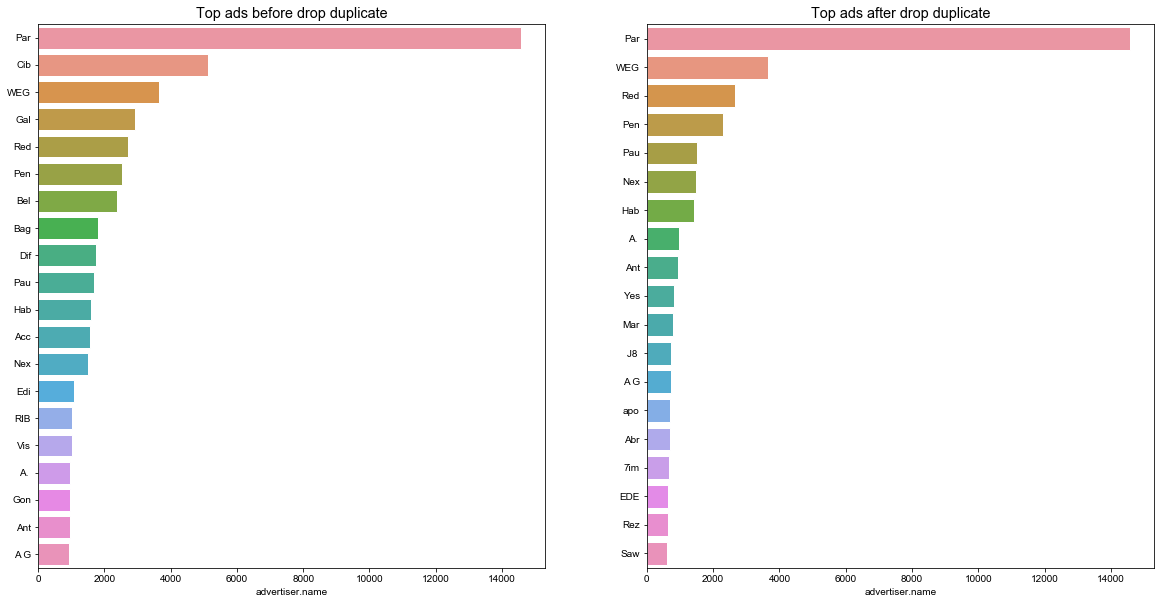

In [12]:
'''
After drop duplicate we can see some company which on the top ads 
before drop duplicate are no longer on the top ads after drop the duplicate data.

Note : After drop duplicate the shape change from 149968 to 92247
'''

top_ads = df_selected['advertiser.name'].value_counts()
top_ads2 = df_ddp['advertiser.name'].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20, 10))
sns.set(font_scale=1.2)
sns.barplot(y=top_ads.index[:20].map(lambda x: x[:3]), x=top_ads.head(20), ax=ax[0]).set_title("Top ads before drop duplicate")
sns.barplot(y=top_ads2.index[:20].map(lambda x: x[:3]), x=top_ads2.head(20), ax=ax[1]).set_title("Top ads after drop duplicate")

Who duplicate the data? 
A. Popular Advertiser -> advertiser.name
B. Third Company -> low top ads advertiser.name
C. The Company Crawler -> scraping.spider_name

### See the distribution of value and cut outlier

Text(0.5, 1.0, 'Value Distribution - Before Cut Outlier')

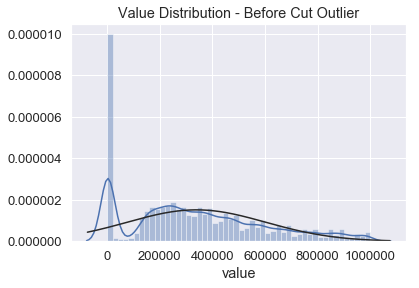

In [13]:
'''
After plot the distribution of value with no drop duplicate of cut outlier, I saw something interest. 
The distribution have two normal curve and it looks like a gaussion mixture and I think that maybe 
I forget something...? may be I have to seperate somethine first.
'''

## Plot Value Distribution
sns.distplot(df_selected[df_selected['value'] < 1*1e6]['value'].dropna(), fit=norm).set_title("Value Distribution - Before Cut Outlier")

#### Beware!! Business Type ( Tipo_Negocio )

In [14]:
'''
The answer is business type because I realize that a rent price and sell price never in the same range.
'''

df_sell = df_ddp[df_ddp['business_type'] == 'Venda']
df_rent = df_ddp[df_ddp['business_type'] == 'Locação']

In [15]:
'''
Before plot distribution of value I seperate value with business type : 'Venda' (Selling), 'Locação' (General)
I use a simple z_score in statistic to cut outlier of value which have more standard deviation than the others.
'''

df_sell['z_value'] = np.abs((df_sell['value'] - df_sell['value'].mean())/df_sell['value'].std(ddof=0))
df_wo_sell = df_sell[df_sell['z_value'] < 1]

df_rent['z_value'] = np.abs((df_rent['value'] - df_rent['value'].mean())/df_rent['value'].std(ddof=0))
df_wo_rent = df_rent[df_rent['z_value'] < 1]

/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Text(0.5, 1.0, 'Value Distribution - Rent After Cut Outlier')

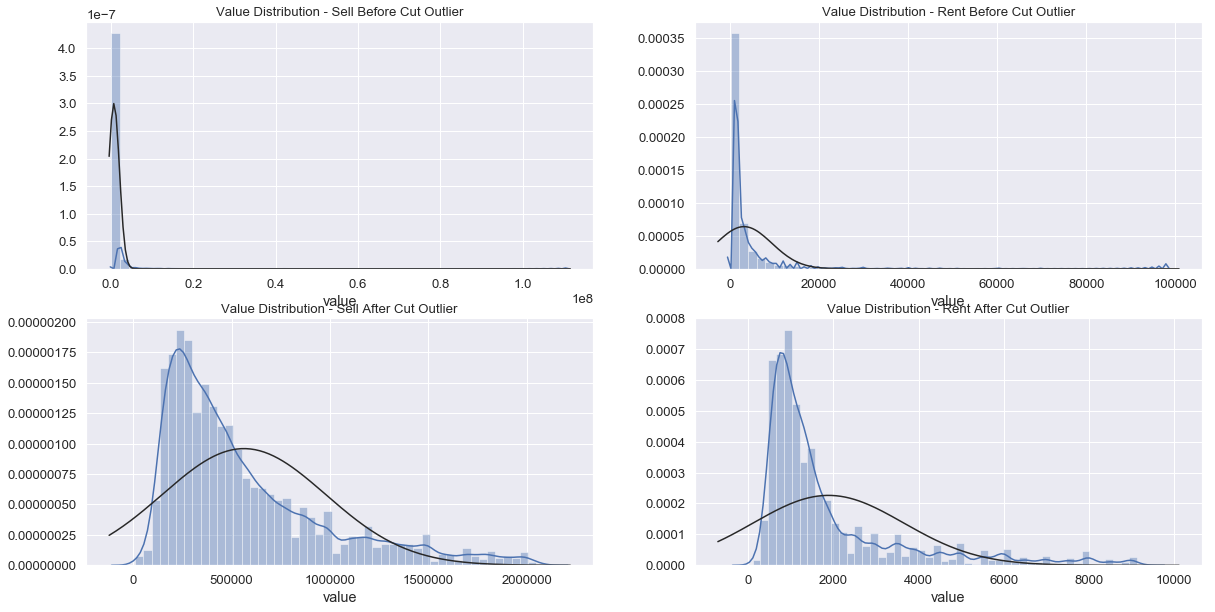

In [16]:
fig, ax = plt.subplots(2,2, figsize=(20, 10))
sns.set(font_scale=1.1)
sns.distplot(df_sell['value'].dropna(), fit=norm, ax=ax[0][0]).set_title("Value Distribution - Sell Before Cut Outlier")
sns.distplot(df_rent['value'].dropna(), fit=norm, ax=ax[0][1]).set_title("Value Distribution - Rent Before Cut Outlier")
sns.distplot(df_wo_sell['value'].dropna(), fit=norm, ax=ax[1][0]).set_title("Value Distribution - Sell After Cut Outlier")
sns.distplot(df_wo_rent['value'].dropna(), fit=norm, ax=ax[1][1]).set_title("Value Distribution - Rent After Cut Outlier")

### Geometry Data

#### Cut Outlier Latitude Longitude

In [17]:
'''
The columns which relate to a geometry are 'latitude', 'longitude', 'geometry.coordinates', 'geohash', 
and 'geometry.type'. Before I dicide to choose geometry.coordinate or lattitude, longitude, I count NaN 
on each columns and see that latitude and longitude column have less NaN than geometry.coordinate. 
But it not significant to choose. And I decide to use latitude and longtitude to lose minimum data. 
'''

df_ddp[['geometry.coordinates', 'latitude', 'longitude']].isnull().sum()

geometry.coordinates    23545
latitude                23533
longitude               23533
dtype: int64

In [18]:
df_dna_geo = df_ddp.dropna(subset=['latitude', 'longitude'], axis=0)

Note : Another way to cut outlier is join dataframe to a map data from shapefile with show in the next step.

In [19]:
# Cut outlier 
df_lat = df_dna_geo['latitude']
df_dna_geo['z_value_lat'] = np.abs((df_lat - df_lat.mean())/df_lat.std(ddof=0))
df_dna_geo = df_dna_geo[df_dna_geo['z_value_lat'] < 1]

df_long = df_dna_geo['longitude']
df_dna_geo['z_value_long'] = np.abs((df_long - df_long.mean())/df_long.std(ddof=0))
df_dna_geo = df_dna_geo[df_dna_geo['z_value_long'] < 1]

/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Value Distribution - After Cut Outlier')

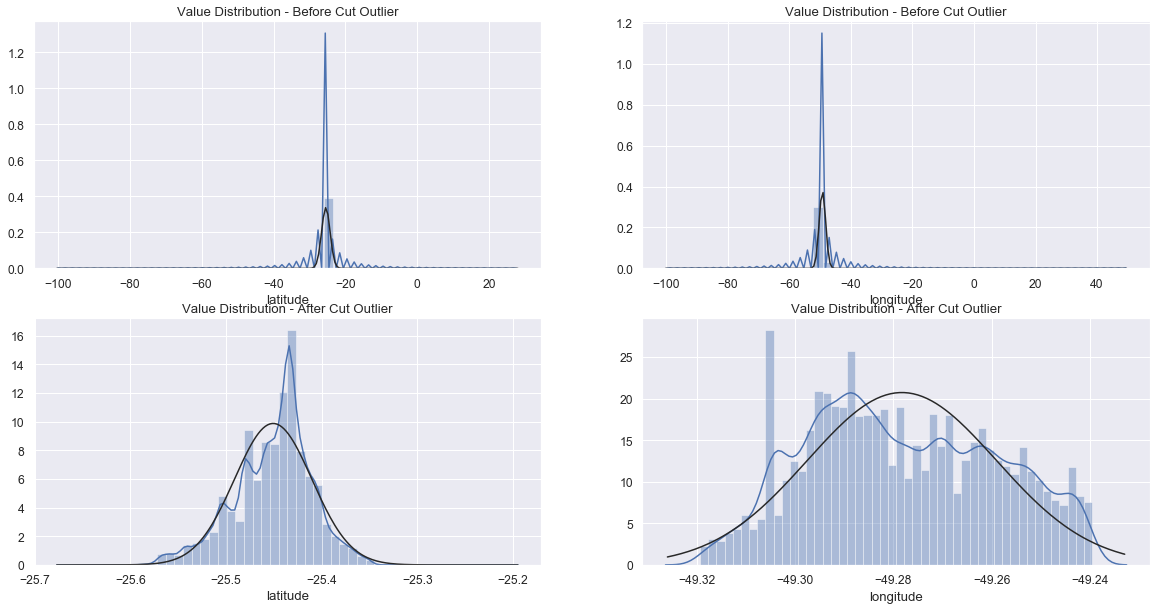

In [20]:
## Plot Value Distribution
fig, ax = plt.subplots(2,2, figsize=(20, 10))
sns.distplot(df_selected['latitude'].dropna(), fit=norm, ax=ax[0][0]).set_title("Value Distribution - Before Cut Outlier")
sns.distplot(df_dna_geo['latitude'], fit=norm, ax=ax[1][0]).set_title("Value Distribution - After Cut Outlier")
sns.distplot(df_selected['longitude'].dropna(), fit=norm, ax=ax[0][1]).set_title("Value Distribution - Before Cut Outlier")
sns.distplot(df_dna_geo['longitude'], fit=norm, ax=ax[1][1]).set_title("Value Distribution - After Cut Outlier")

#### Plot on map!

In [21]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [22]:
# Download Curitiba Map from this site http://ippuc.org.br/geodownloads/geo.htm
nbh_border_path = './geo/realties/DIVISA_DE_BAIRROS.shp'
nbh_border = gpd.read_file(nbh_border_path)
nbh_border_shape = nbh_border.to_crs({'init':'epsg:4326'})

In [23]:
zone_path = './geo/Brazil-Curitiba-Zone-SAD69_CWB/ZONEAMENTO.shp'
zone = gpd.read_file(zone_path)
zone_shape = zone.to_crs({'init':'epsg:4326'})

In [52]:
# Create geometry column to work with geopandas
geometry = [Point(xy) for xy in zip(df_dna_geo['longitude'], df_dna_geo['latitude'])]
df_dna_geo = gpd.GeoDataFrame(df_dna_geo, crs={'init':'epsg:4326'}, geometry=geometry)

In [53]:
# Create Neighborhood Map and Zone Map
union_nbh = gpd.sjoin(nbh_border_shape, df_dna_geo, op='intersects')
union_zone = gpd.sjoin(zone_shape, df_dna_geo, op='intersects')

Find the top place which show on ads grouping by neighborhood name.

CPU times: user 14.4 s, sys: 257 ms, total: 14.6 s
Wall time: 14.9 s


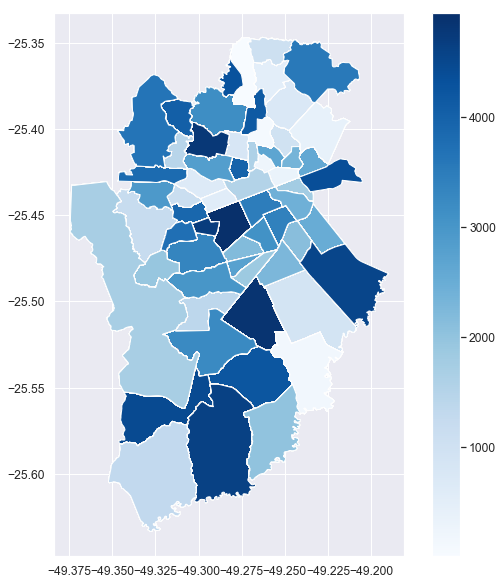

In [59]:
%%time
df_dna_geo['neighborhood.name'] = df_dna_geo['neighborhood.name'].str.upper()
top_ads_by_nbh = df_dna_geo['neighborhood.name'].value_counts().to_frame()

# fig, ax = plt.subplots(figsize = (30,25))
vmax, vmin = 4944, 3
ax = union_nbh.plot(figsize=(10, 10), column='NOME', cmap='Blues', k=5)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=ax)

Find top mean average selling price grouping by neighborhood name.

/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 1.32 s, sys: 1.46 s, total: 2.78 s
Wall time: 2.95 s


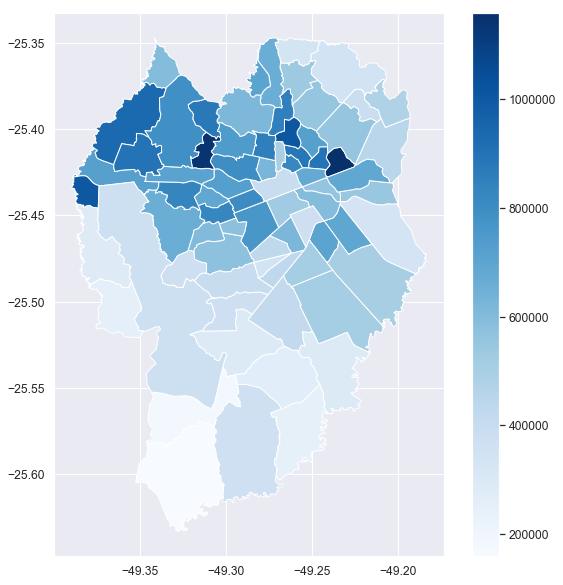

In [56]:
%%time
df_wo_sell['neighborhood.name'] = df_wo_sell['neighborhood.name'].str.upper()
heatmap_value = df_wo_sell.groupby(['neighborhood.name'], as_index=False).mean()
geometry = [Point(xy) for xy in zip(heatmap_value['longitude'], heatmap_value['latitude'])]
heatmap_value = gpd.GeoDataFrame(heatmap_value, crs={'init':'epsg:4326'}, geometry=geometry)
union_nbh_value = gpd.sjoin(nbh_border_shape, heatmap_value, op='intersects')

# fig, ax = plt.subplots(figsize = (30,25))
vmax, vmin = union_nbh_value.value.max(), union_nbh_value.value.min()

ax = union_nbh_value.plot(figsize=(10, 10), column='value', cmap='Blues')
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=ax)

Compare with bar chart plot : Top 20 High Selling Price Neighborhood

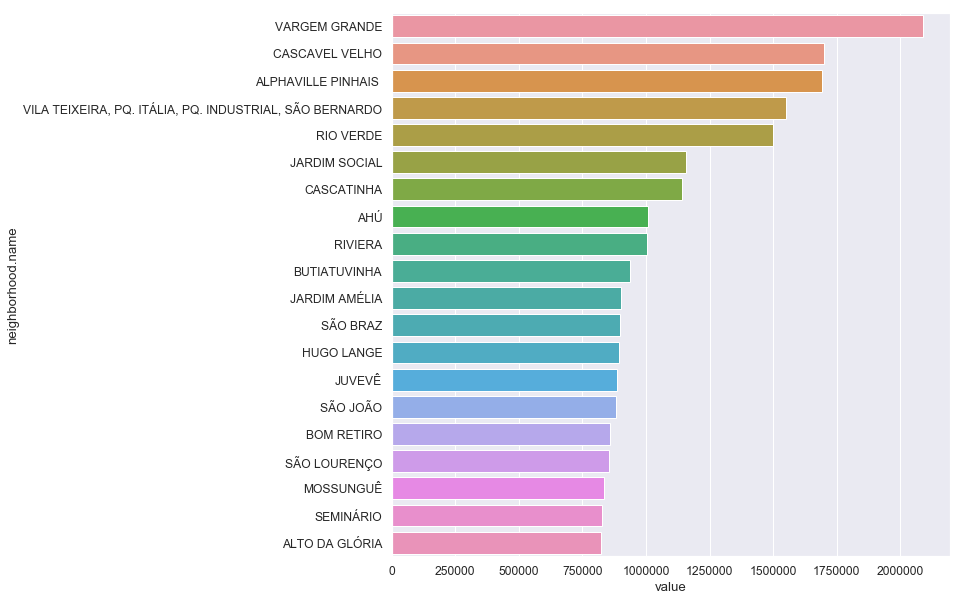

In [60]:
top_mean_price = df_wo_sell[['neighborhood.name', 'value']].groupby(['neighborhood.name'], as_index=False).mean()
plt.figure(figsize=(10, 10))
ax = sns.barplot(x="value", y="neighborhood.name", data=top_mean_price.sort_values(by=('value'), ascending=False).head(20))

## Property Tax Analysis

In [62]:
df_prop_tax = df_ddp
df_prop_tax['z_value'] = np.abs((df_prop_tax['iptu'] - df_prop_tax['iptu'].mean())/df_prop_tax['iptu'].std(ddof=0))
df_wo_prop_tax = df_prop_tax[df_prop_tax['z_value'] < 1]

/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Property Tax Distribution - After Cut outlier')

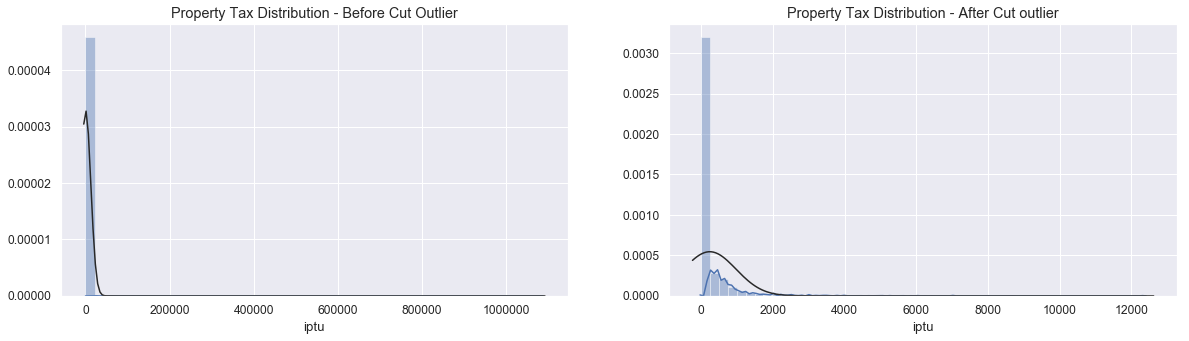

In [63]:
fig, ax = plt.subplots(1,2, figsize=(20, 5))
sns.set(font_scale=1.2)
sns.distplot(df_ddp['iptu'].dropna(), fit=norm, ax=ax[0]).set_title("Property Tax Distribution - Before Cut Outlier")
sns.distplot(df_wo_prop_tax['iptu'].dropna(), fit=norm, ax=ax[1]).set_title("Property Tax Distribution - After Cut outlier")

Find top mean average tax price grouping by zone name.

CPU times: user 232 ms, sys: 15.8 ms, total: 248 ms
Wall time: 250 ms


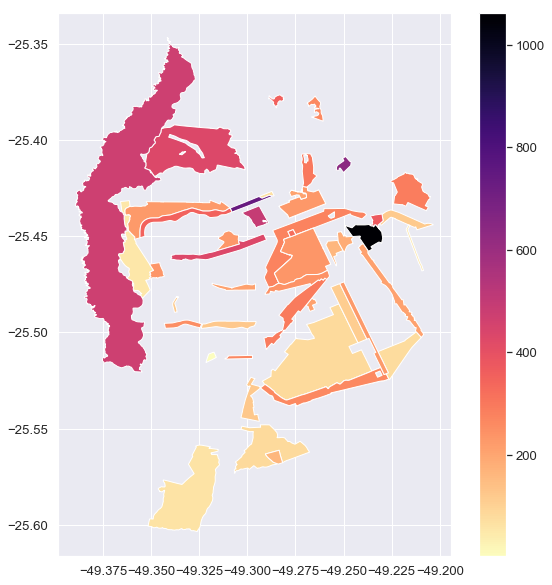

In [65]:
%%time

#To avoid dealing with zoning name match I decide to match with zoning id
heatmap_prop_tax = df_wo_prop_tax.groupby(['zoning.initials'], as_index=False).mean()
geometry = [Point(xy) for xy in zip(heatmap_prop_tax['longitude'], heatmap_prop_tax['latitude'])]
heatmap_prop_tax = gpd.GeoDataFrame(heatmap_prop_tax, crs={'init':'epsg:4326'}, geometry=geometry)
union_zone_prop_tax = gpd.sjoin(zone_shape, heatmap_prop_tax, op='intersects')

# fig, ax = plt.subplots(figsize = (30,25))
vmax, vmin = union_zone_prop_tax.iptu.max(), union_zone_prop_tax.iptu.min()

ax = union_zone_prop_tax.plot(figsize=(10, 10), column='iptu', cmap='magma_r')
sm = plt.cm.ScalarMappable(cmap='magma_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=ax)

Compare with bar chart plot : Top High Tax Price Zone

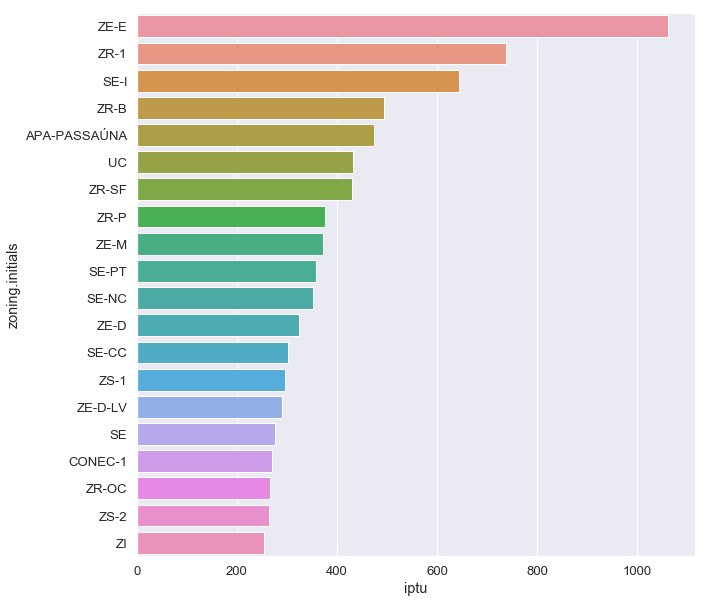

In [70]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x="iptu", y="zoning.initials", data=heatmap_prop_tax.sort_values(by=('iptu'), ascending=False).head(20))

## Property Type Analysis

A main_property_type column is the one of a headache column that I have to deal with. First they contain in type of list data and second some ads have more than one property type.

To category them and count the most property type which were advertised, I choose choose just the firt index of the list and convert it to string.

In [71]:
df_ddp['main_property_type'] = df_ddp['property_type'].apply(lambda x: sorted(x)).apply(lambda x: [x[0]]).apply(' ,'.join)

/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


A Apartment(Apartmento) is top list of property type which were advertised.

[Text(0.5, 0, 'ads count')]

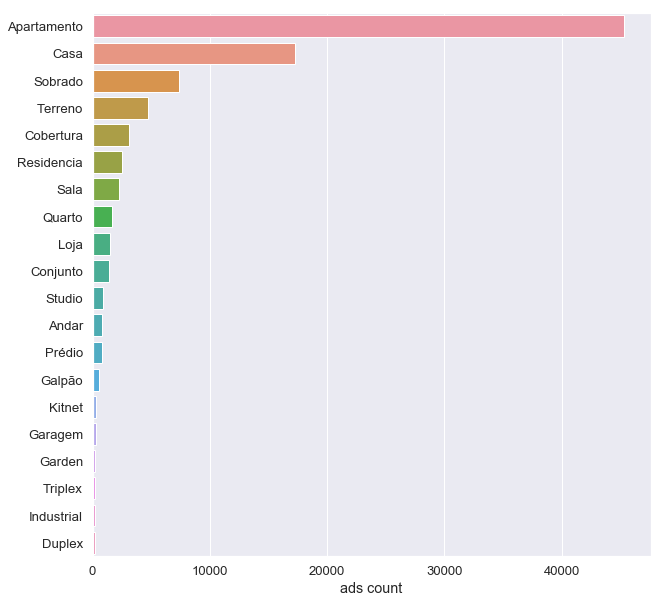

In [72]:
df_ddp['main_property_type'].value_counts()
top_prop_type = df_ddp['main_property_type'].value_counts()
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.2)
ax = sns.barplot(y=top_prop_type.index[:20], x=top_prop_type.head(20))
ax.set(xlabel='ads count')

### The most property type advertise by who?

In [75]:
## From top advertiser
top_ads.index[0:10]

Index(['Particular - OLX', 'Cibraco', 'WEGA IMÓVEIS', 'Galvão Locações',
       'Rede Bee', 'Penty Consultora - VivaReal',
       'Bella Torre Imóveis Bella Torre Imóveis', 'Baggio',
       'Diferencial Imóveis Ltda - VivaReal',
       'Paulo Rogério Bernardo Orlandini - VivaReal'],
      dtype='object')

In [76]:
gp_prop_type = df_ddp.groupby(['main_property_type'], as_index=False).count()
top_ads_cat = df_selected.groupby(['advertiser.name'], as_index=False).count()

In [77]:
test = df_ddp[df_ddp['advertiser.name'] == '7imóveis - VivaReal']
test['main_property_type'].value_counts()

Apartamento    455
Casa            94
Cobertura       34
Quarto          26
Studio          15
Sobrado         14
Sala            10
Andar            5
Residencia       5
Duplex           5
Garden           5
Terreno          3
Garagem          2
Loft             1
Prédio           1
Name: main_property_type, dtype: int64

In [1]:
frame = {}
for name in df_ddp.main_property_type.unique():
    test = pd.Series(df_ddp[df_ddp['main_property_type'] == name].groupby(['advertiser.name']).count()['main_property_type'])
    frame[name] = test
    
result = pd.DataFrame(frame)
result = result.reset_index()
result = result.rename(columns={'index':'advertiser.name'}).fillna(0)

NameError: name 'df_ddp' is not defined